## Modelling hotel cancellations

<a id='intro'></a>
# Introduction

This data set contains information on 119,390 hotel bookings between July 2015 and August 2017. Each observation represents a hotel booking.

The data for two hotels is given. Both hotels are located in Portugal: the Resort Hotel is in the region of the Algarve and the City Hotel is in the city of Lisbon. A variety of categorical and numeric features are provided, including whether the book was cancelled.

Hotel management would find it useful to be able to predict whether a booking is likely to be cancelled.

<a id='import'></a>
# Importing libraries and data

<a id='libraries'></a>
## Importing the libraries

In [28]:
# pandas for data analysis
import pandas as pd

# seaborn for visualisation
import seaborn as sns
sns.set_context("talk")

# seaborn has some unhelpful warnings at the moment
import warnings
warnings.filterwarnings("ignore", module="seaborn")

# Import functions from sklearn for building the model, training-testing split, visualising the model and metrics 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Function to draw the model
def plot_decision_tree(tree_model):
    fig, ax = plt.subplots(figsize=(20,8))
    plot_tree(tree_model,  
        filled=True, 
        impurity=False, 
        feature_names=input_features, 
        class_names=["No","Yes"], 
        proportion=True, 
        ax=ax)
    plt.show()

<a id='data'></a>
## Importing the data

In [2]:
hotel_data = pd.read_csv('../input/hotel-bookings/bookings_2025.csv')
hotel_data

,hotel,meal,market_segment,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,total_of_special_requests,adr,is_canceled
0,Resort Hotel,BB,Direct,342,0,0,2,0.0,0,0,0,0,3,0,0,0.00,0
1,Resort Hotel,BB,Direct,737,0,0,2,0.0,0,0,0,0,4,0,0,0.00,0
2,Resort Hotel,BB,Direct,7,0,1,1,0.0,0,0,0,0,0,0,0,75.00,0
3,Resort Hotel,BB,Corporate,13,0,1,1,0.0,0,0,0,0,0,0,0,75.00,0
4,Resort Hotel,BB,Online TA,14,0,2,2,0.0,0,0,0,0,0,0,1,98.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,BB,Offline TA/TO,23,2,5,2,0.0,0,0,0,0,0,0,0,96.14,0
119386,City Hotel,BB,Online TA,102,2,5,3,0.0,0,0,0,0,0,0,2,225.43,0
119387,City Hotel,BB,Online TA,34,2,5,2,0.0,0,0,0,0,0,0,4,157.71,0
119388,City Hotel,BB,Online TA,109,2,5,2,0.0,0,0,0,0,0,0,0,104.40,0


In [3]:
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   meal                            119390 non-null  object 
 2   market_segment                  119390 non-null  object 
 3   lead_time                       119390 non-null  int64  
 4   stays_in_weekend_nights         119390 non-null  int64  
 5   stays_in_week_nights            119390 non-null  int64  
 6   adults                          119390 non-null  int64  
 7   children                        119386 non-null  float64
 8   babies                          119390 non-null  int64  
 9   is_repeated_guest               119390 non-null  int64  
 10  previous_cancellations          119390 non-null  int64  
 11  previous_bookings_not_canceled  119390 non-null  int64  
 12  booking_changes 

<a id='pre'></a>
# Preparing the data and exploratory data analysis


In [4]:
hotel_data['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

37% of reservations are cancelled. The difference in the dataset is mild. Therefore, memory and precision are more crucial than accuracy alone.

In [5]:
pd.crosstab(
    hotel_data['hotel'],
    hotel_data['is_canceled'],
    normalize='index'
)

is_canceled,0,1
hotel,,
City Hotel,0.582730,0.417270
Resort Hotel,0.722366,0.277634


The cancellation rate is significantly higher at city hotels. Shorter, more flexible, and work-related stays are common in cities.The type of hotel is a reliable indicator as in business it is more common that stays will be cancelled aswell since the hotels are usually cheaper than the resorts.

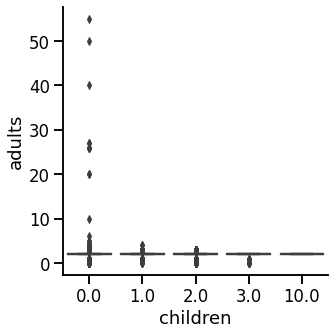

In [6]:
sns.catplot(data=hotel_data, kind='box', x='children', y='adults', aspect=1);

We can see here that as the number of children increase the amount of adults decrease. This may be due to planning constraints and a higher overall cost. 

In [7]:
pd.crosstab(
    hotel_data['children'],
    hotel_data['is_canceled'],
    normalize='index'
)

is_canceled,0,1
children,,
0.0,0.629102,0.370898
1.0,0.677638,0.322362
2.0,0.578039,0.421961
3.0,0.776316,0.223684
10.0,0.000000,1.000000


We can see that the cancellation rate is when people have 2 children. This maybe due to the fact that this is more likely to be a family holiday which maybe more hard to commit to. This is because there are more varibales involved such as illness that could infulence the cancellation. However, we also must consider that this is a very large group leading to a higher chance of cancellations. 

<Figure size 432x288 with 0 Axes>

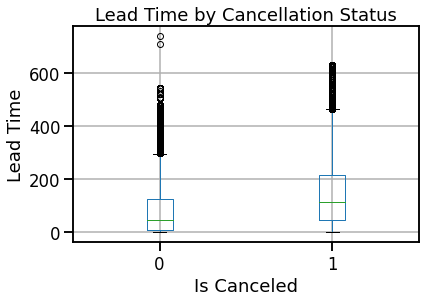

In [8]:
plt.figure()
hotel_data.boxplot(column='lead_time', by='is_canceled')
plt.title("Lead Time by Cancellation Status")
plt.suptitle("")
plt.xlabel("Is Canceled")
plt.ylabel("Lead Time")
plt.show()

Lead times for cancelled reservations are much longer. Clients who make reservations well in advance are less certain. Lead time ought to be an essential part of the model since it willeffect the decision making aspect of the client.

In [9]:
pd.crosstab(
    hotel_data['market_segment'],
    hotel_data['is_canceled'],
    normalize='index'
).sort_values(by=1, ascending=False)

is_canceled,0,1
market_segment,,
Undefined,0.000000,1.000000
Groups,0.389380,0.610620
Online TA,0.632789,0.367211
Offline TA/TO,0.656840,0.343160
Aviation,0.780591,0.219409
Corporate,0.812653,0.187347
Direct,0.846581,0.153419
Complementary,0.869448,0.130552


Bookings made through online travel agents  have a very high cancellation rate. Direct reservations are far more reliable. The distribution channel has a significant impact on cancellation behaviour. This maybe due to the fact that the hotel OTA may book multiple hotels to secure the cheapest price for a client. 

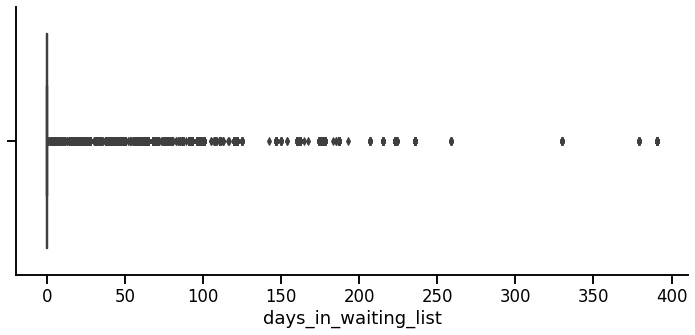

In [10]:
sns.catplot(data=hotel_data, kind='box', x='days_in_waiting_list',aspect=2);

We can see that people usually spend inbetween 0-100 days in the waiting list. However we do see a decreasing trend after that abd then we may have a few anomolies from the 250-400 range. 

<Figure size 432x288 with 0 Axes>

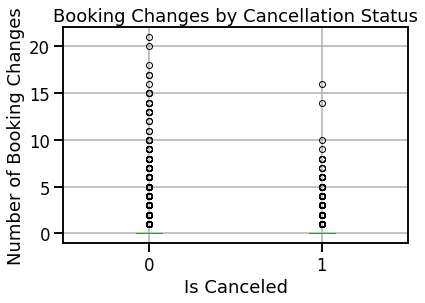

In [11]:
plt.figure()
hotel_data.boxplot(column='booking_changes', by='is_canceled')
plt.title("Booking Changes by Cancellation Status")
plt.suptitle("")
plt.xlabel("Is Canceled")
plt.ylabel("Number of Booking Changes")
plt.show()

Reservations with more modifications are more likely to be cancelled. Several changes point to uncertainty. This characteristic offers helpful behavioural insight. It relates to this s then if people make many modification they may not be certain if they are travelling or not. 

<Figure size 432x288 with 0 Axes>

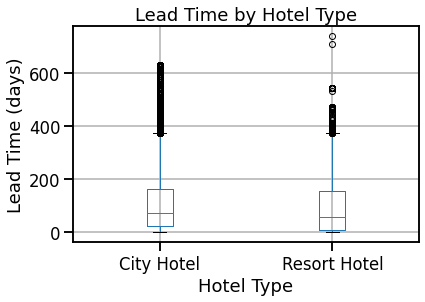

In [12]:
plt.figure()
hotel_data.boxplot(column='lead_time', by='hotel')
plt.title("Lead Time by Hotel Type")
plt.suptitle("")
plt.xlabel("Hotel Type")
plt.ylabel("Lead Time (days)")
plt.show()

This box plot shows that City Hotel bookings tend to have longer lead times than Resort Hotel bookings, this may be because city trips are often planned further in advance such as for business visits.


<Figure size 432x288 with 0 Axes>

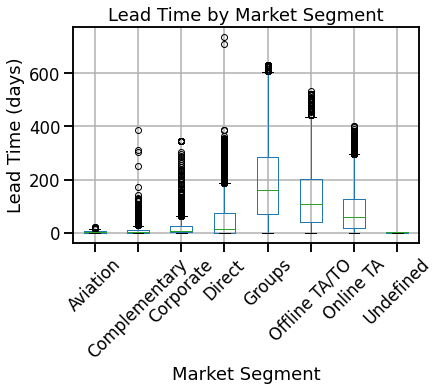

In [13]:
plt.figure()
hotel_data.boxplot(column='lead_time', by='market_segment')
plt.title("Lead Time by Market Segment")
plt.suptitle("")
plt.xlabel("Market Segment")
plt.ylabel("Lead Time (days)")
plt.xticks(rotation=45)
plt.show()

The box plot shows that bookings made through Online Travel Agents usually have higher lead times. These bookings are also easier to cancel, which helps explain why this market segment has a higher cancellation rate.


<a id='model'></a>
# Building models

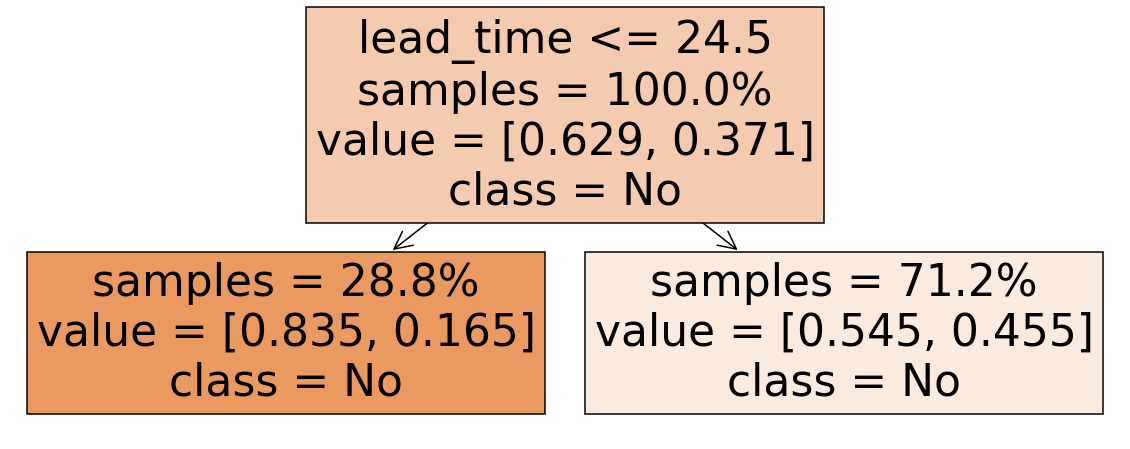

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0)

In [14]:
input_features = ['lead_time']
X = hotel_data[input_features]
y = hotel_data['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

tree_model_1 = DecisionTreeClassifier(max_depth=1, random_state=1)
tree_model_1.fit(X_train, y_train)

plot_decision_tree(tree_model_1)
plt.show()

y_pred = tree_model_1.predict(X_test)

pd.crosstab(
    y_test,
    y_pred,
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True
)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

Very simple model. Uses one feature only so it acts as a baseline.

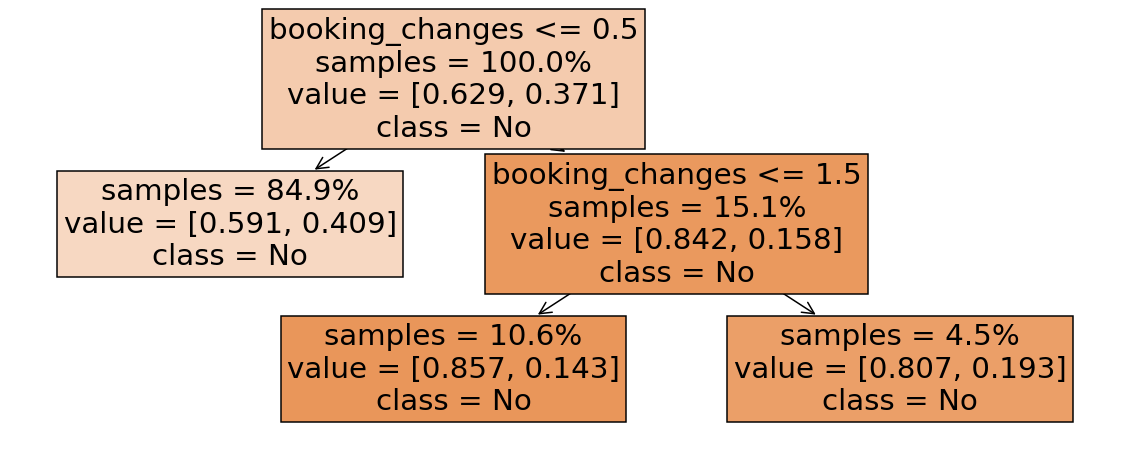

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0)

In [15]:
input_features = ['booking_changes']
X = hotel_data[input_features]
y = hotel_data['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

tree_model_2 = DecisionTreeClassifier(max_depth=2, random_state=1)
tree_model_2.fit(X_train, y_train)

plot_decision_tree(tree_model_2)
plt.show()
y_pred = tree_model_2.predict(X_test)

pd.crosstab(
    y_test,
    y_pred,
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True
)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

For model one and two: For these models, the precision is zero because the decision tree predicted only one outcome, which was the majority class (not cancelled). This happens because the tree is very shallow and the data is imbalanced, so the model is not complex enough to spot the chance of cancellations properly. This shows that very simple models are limited, which is why later models use more features and deeper trees to improve performance and achieve more accurate results.

Slightly better than Model 1. Captures customer uncertainty.

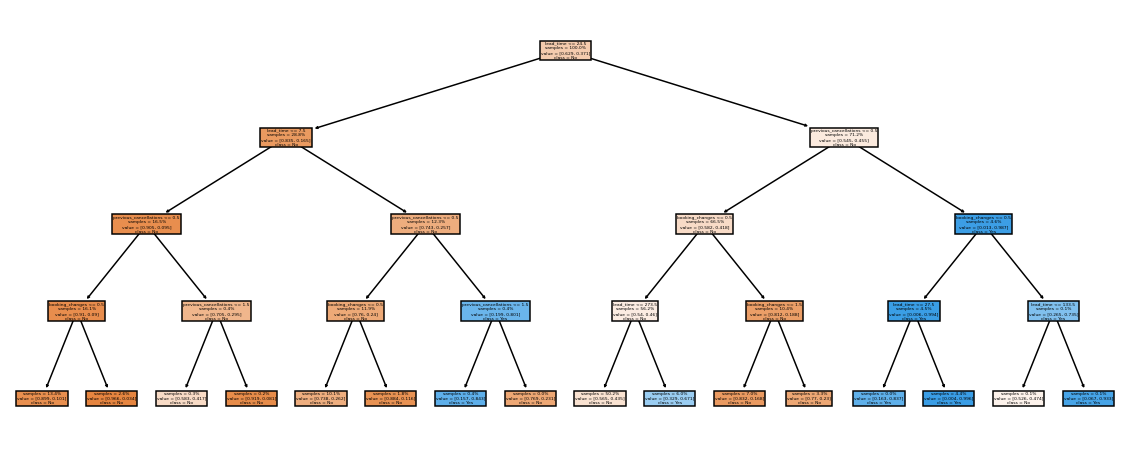

(0.807219357397858, 0.23185598723937564)

In [16]:
input_features = ['lead_time', 'booking_changes', 'previous_cancellations']
X = hotel_data[input_features]
y = hotel_data['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

tree_model_3 = DecisionTreeClassifier(max_depth=4, random_state=1)
tree_model_3.fit(X_train, y_train)

plot_decision_tree(tree_model_3)
plt.show()

y_pred = tree_model_3.predict(X_test)

pd.crosstab(
    y_test,
    y_pred,
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True
)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

Much stronger performance as it takes in users behaviour history. Clear improvement to other models. 

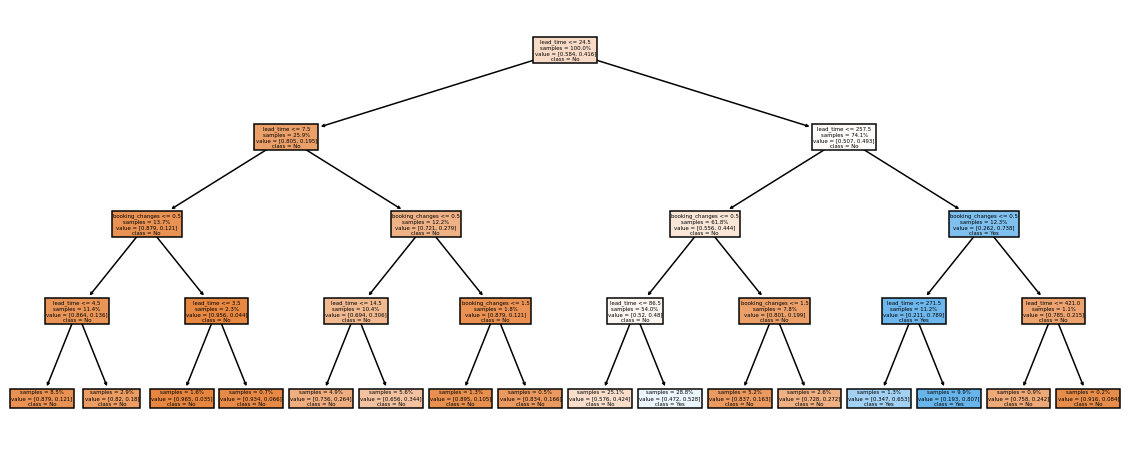

(0.6042468072011079, 0.5857696897374701)

In [17]:
city_hotel = hotel_data[hotel_data['hotel'] == 'City Hotel']

input_features = ['lead_time', 'booking_changes']
X = city_hotel[input_features]
y = city_hotel['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

tree_model_4 = DecisionTreeClassifier(max_depth=4, random_state=1)
tree_model_4.fit(X_train, y_train)

plot_decision_tree(tree_model_4)
plt.show()

y_pred = tree_model_4.predict(X_test)

pd.crosstab(
    y_test,
    y_pred,
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True
)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)


Performance improves when slicing data, confirms City Hotel behaviour is different.

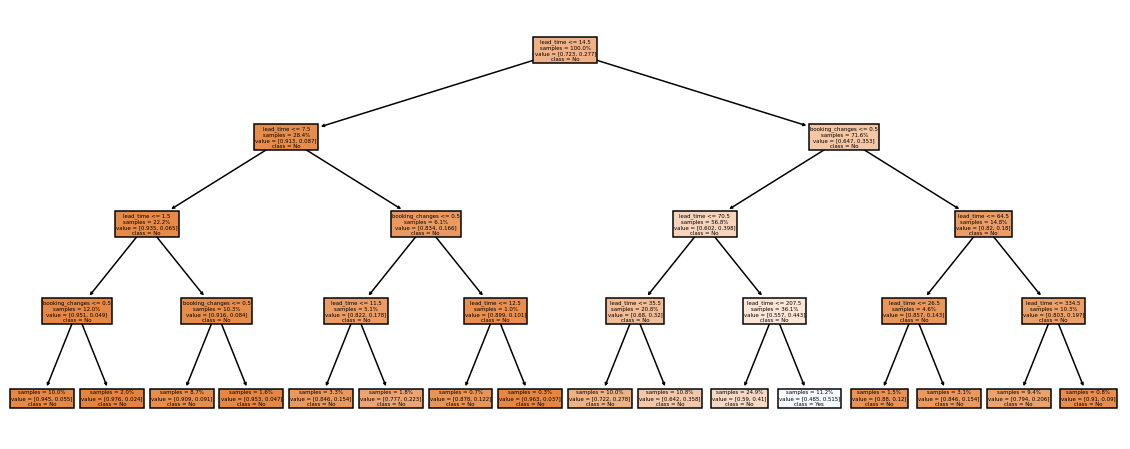

(0.5244755244755245, 0.20170327207530256)

In [18]:
resort_hotel = hotel_data[hotel_data['hotel'] == 'Resort Hotel']

input_features = ['lead_time', 'booking_changes']
X = resort_hotel[input_features]
y = resort_hotel['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

tree_model_5 = DecisionTreeClassifier(max_depth=4, random_state=1)
tree_model_5.fit(X_train, y_train)

plot_decision_tree(tree_model_5)
plt.show()

y_pred = tree_model_5.predict(X_test)

pd.crosstab(
    y_test,
    y_pred,
    rownames=['Actual'],
    colnames=['Predicted'],
    margins=True
)

precision_score(y_test, y_pred), recall_score(y_test, y_pred)

Lower cancellation rates. Model behaves differently than City Hotel and confirms need for sliced models.

In [29]:
input_features = ['adults']
X = hotel_data[input_features]
y = hotel_data['stays_in_week_nights']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

# create the model and display the parameters - output the coefficients and y-intercept
linear_model = LinearRegression().fit(X_train,y_train)
print('Coefficients: \n', linear_model.coef_.round(3))
print('Intercept: \n', linear_model.intercept_.round(3))

# create a list of the predictions and calculate the metrics (RMSE and R² score) by to the target values in y_test
y_pred = linear_model.predict(X_test) 
print('RMSE: ',mean_squared_error(y_test, y_pred, squared=False).round(3))
print('R²: ',(100*r2_score(y_test, y_pred)).round(3),"%")


Coefficients: 
 [0.322]
Intercept: 
 1.9
RMSE:  1.924
R²:  0.685 %


The coefficient of 0.322 shows a weak positive relationship, meaning bookings with more adults tend to stay slightly longer, but the RMSE of 1.924 indicates a fairly large prediction error. An R² of 0.685% shows that the number of adults explains very little of the variation in week-night stays, so this model is a poor predictor on its own.

In [30]:
input_features = ['adults']
X = hotel_data[input_features]
y = hotel_data['babies']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
linear_model = LinearRegression().fit(X_train,y_train)
print('Coefficients: \n', linear_model.coef_.round(3))
print('Intercept: \n', linear_model.intercept_.round(3))
y_pred = linear_model.predict(X_test) 
print('RMSE: ',mean_squared_error(y_test, y_pred, squared=False).round(3))
print('R²: ',(100*r2_score(y_test, y_pred)).round(3),"%")

Coefficients: 
 [0.003]
Intercept: 
 0.002
RMSE:  0.109
R²:  0.022 %


This model has a extremely weak positive relationship as the coefficient is 0.003, this shows us that more adults are coming with babies but it is a slow increase. The RMSE here tells us that there is a low preidcition error. Due to the low R² this is also a poor model as this is a low coefficient for determination.

In [41]:
input_features = ['total_of_special_requests']
X = hotel_data[input_features]
y = hotel_data['adr']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
linear_model = LinearRegression().fit(X_train,y_train)
print('Coefficients: \n', linear_model.coef_.round(3))
print('Intercept: \n', linear_model.intercept_.round(3))
y_pred = linear_model.predict(X_test) 
print('RMSE: ',mean_squared_error(y_test, y_pred, squared=False).round(3))
print('R²: ',(100*r2_score(y_test, y_pred)).round(3),"%")

Coefficients: 
 [11.15]
Intercept: 
 95.622
RMSE:  47.765
R²:  2.772 %


The model shows that each additional special request increases the average daily rate by about £11, but the relationship is very weak. With an R² of only 2.77%, this feature explains almost none of the variation in adr, so it’s not a strong predictor on its own.

# Conclusions

The EDA showed a large difference between cancelled bookings and bookings that have not been cancelled. Variables such as “lead time” and “bookings changes” indicated a large amount of information with a fairly predictable outcome. It was also indicated that there is a difference between the types of bookings. This indicated why slicing the data was effective. The results indicated that the machine learning models proved that a simple solution can be applied effectively at the beginning. However, it lacks effectiveness. This was particularly effective when splitting the data according to the types of the involved hotels. The above project proves that it is possible to reasonably predict cancellation patterns based on previous booking information. However, these models can be applied for the use to aid decision making as we can still have unpredictable customer behaviour. However, with the combination of the models and the EDA the hotel managment can make a resonable assumtpion whether a guest will cancel or not. 